# QSO Targets Selection with DR8

Insight in the QSO targets selection.

Notebook was written by Charles-Antoine Claveau. See *RF_training_generator_example.ipynb* for the current version of the training with DR9.

----------------------
----------------------

The purpose of this study is to explore the QSO target selection using the DR8b pre-release, and interpretability of the random forest model.

The baseline random-forest selection is described [here](https://desi.lbl.gov/trac/wiki/TargetSelectionWG/TargetSelection#QuasarsQSO22:MultivariateSelection). 

Truth matched catalogs are described [here](https://desi.lbl.gov/trac/wiki/TargetSelectionWG/TargetingTruthTables) and [here](https://desi.lbl.gov/trac/wiki/TargetSelectionWG/TargetingTruthTables/MatchedTruthCatalogs).

---------
---------

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

In [3]:
from pathlib import Path

In [4]:
import astropy.table
import astropy.io.fits as fits
import astropy.coordinates
import astropy.units as u

In [43]:
from sklearn import ensemble, model_selection

In [6]:
import desitarget.cuts
import desitarget.train.train_mva_decals

## DR8b Validation

Locate the data at NERSC:

In [7]:
Truth = Path('/project/projectdirs/desi/target/analysis/truth/')
assert Truth.exists

In [8]:
release = 'dr8b'
assert (Truth / release).exists

Define the [stripe 82](https://en.wikipedia.org/wiki/Stripe_82) footprint:

In [9]:
def in_stripe82(ra, dec):
    ra_hr = ra * 24 / 360
    return (dec > -1.26) & (dec < 1.26) & ((ra_hr > 20) | (ra_hr < 4))

Load a truth-matched catalog, and flag objects in stripe 82:

In [10]:
def load_matched(name='sdss-specObj-dr14-unique-trimmed', survey='decam', release=release):
    fullname = name + '-match.fits'
    path = Truth / release / survey
    assert path.exists
    # Why does prefix contain decals even for 90prine-mosaic? (reported this to Rongpu)
    prefix = f'decals-{release}'
    external = astropy.table.Table.read(path / 'matched' / f'{name}-match.fits')
    matched = astropy.table.Table.read(path / 'matched' / f'{prefix}-{name}-match.fits')
    # Look up unmatched QSOs.
    allobjs = np.load(path / 'allobjects' / f'{prefix}-{name}.npy')
    parent = astropy.table.Table.read(Truth / 'parent' / f'{name}.fits')
    unmatched_QSO = ~allobjs & (parent['CLASS'] == 'QSO   ')
    unmatched = parent[unmatched_QSO]
    unmatched['STRIPE82'] = 1 * in_stripe82(unmatched['PLUG_RA'], unmatched['PLUG_DEC'])
    n82 = np.count_nonzero(unmatched['STRIPE82'])
    print(f'Found {len(unmatched)} unmatched QSOs ({n82} in Stripe 82).')
    # Merge the matched catalogs.
    merged = astropy.table.hstack((external, matched))
    merged['STRIPE82'] = 1 * in_stripe82(merged['RA'], merged['DEC'])
    n82 = np.count_nonzero(merged['STRIPE82'])
    print(f'Loaded matched catalog for "{name}" with {len(merged)} entries ({n82} in Stripe 82).')
    return merged, unmatched

Load the north and south DR8b catalogs matched to DR14 objects:

In [11]:
DR14N, _ = load_matched(survey='90prime-mosaic')

Found 821224 unmatched QSOs (49948 in Stripe 82).
Loaded matched catalog for "sdss-specObj-dr14-unique-trimmed" with 19949 entries (0 in Stripe 82).


In [12]:
DR14S, unmatched = load_matched(survey='decam')

Found 790236 unmatched QSOs (26598 in Stripe 82).
Loaded matched catalog for "sdss-specObj-dr14-unique-trimmed" with 178729 entries (125236 in Stripe 82).


Plot densities in stripe 82 for detected DR8b objects matched to DR14 quasars:

In [13]:
def plot82(ra, dec):
    ra[ra > 180] -= 360
    rabins = np.linspace(-60, 60, 60)
    decbins = np.linspace(-1.26, +1.26, 10)
    density, _, _ = np.histogram2d(dec, ra, bins=(decbins, rabins))
    binarea = (decbins[1] - decbins[0]) * (rabins[1] - rabins[0])
    density /= binarea
    plt.figure(figsize=(12, 4))
    vmin, vmax = 0, 300 #np.percentile(density[density > 0], (1, 99))
    plt.imshow(density, extent=(rabins[0], rabins[-1], decbins[0], decbins[-1]),
               aspect='auto', interpolation='none', origin='lower', vmin=vmin, vmax=vmax)
    plt.grid(False)
    plt.xlabel('RA [deg]')
    plt.ylabel('DEC [deg]')
    plt.colorbar().set_label('QSO density / sq.deg.')

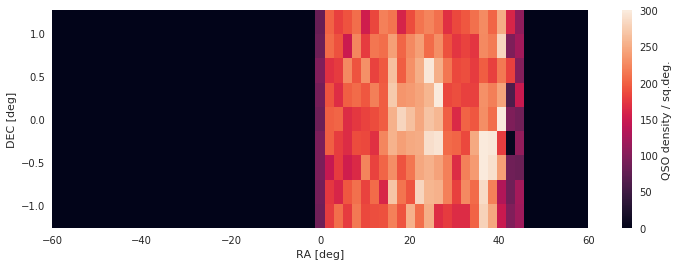

In [14]:
QSOin82 = (DR14S['CLASS'] == 'QSO   ') & (DR14S['STRIPE82'] == 1)
plot82(DR14S['RA'][QSOin82], DR14S['DEC'][QSOin82])

Do the same plot for DR14 stripe 82 quasars that were **not** detected in DR8b:

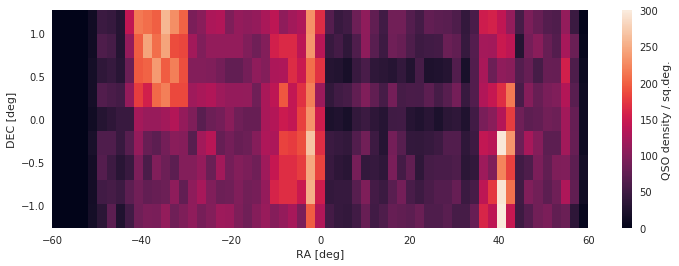

In [15]:
QSOin82 = (unmatched['STRIPE82'] == 1)
plot82(unmatched['PLUG_RA'][QSOin82], unmatched['PLUG_DEC'][QSOin82])

Compare the redshift distributions of DR14 stripe 82 quasars detected or undetected in DR8b:

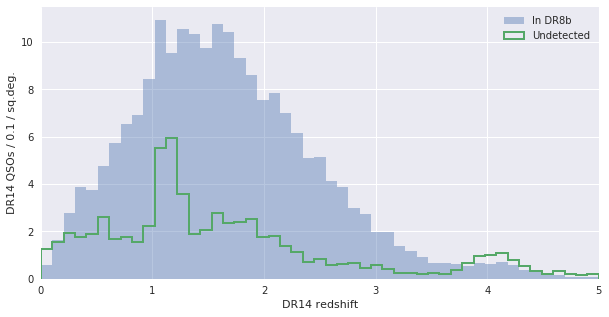

In [16]:
def plot_undetected():
    # Lookup detected objects in RA 0-45 deg of stripe 82.
    area = 45 * 1.26 * 2
    detected = np.where(
        (DR14S['CLASS'] == 'QSO   ') & (DR14S['STRIPE82'] == 1) &
        (DR14S['PLUG_RA'] > 0) & (DR14S['PLUG_RA'] < 45))[0]
    z_detected = DR14S[detected]['Z']
    # Lookup undetected objects in the same region.
    undetected = np.where(
        (unmatched['STRIPE82'] == 1) &
        (unmatched['PLUG_RA'] > 0) & (unmatched['PLUG_RA'] < 45))[0]
    z_undetected = unmatched[undetected]['Z']
    t = astropy.table.Table()
    t['Name'] = [f'z={z:.3f}' for z in z_undetected]
    t['RA'] = unmatched[undetected]['PLUG_RA']
    t['DEC'] = unmatched[undetected]['PLUG_DEC']
    t = t[np.argsort(z_undetected)[::-1]]
    # Compare the redshift distributions.
    zbins = np.linspace(0, 5, 50)
    plt.figure(figsize=(10, 5))
    plt.hist(z_detected, bins=zbins, weights=np.ones(len(detected)) / area, alpha=0.4, label='In DR8b')
    plt.hist(z_undetected, bins=zbins, weights=np.ones(len(undetected)) / area, histtype='step', lw=2, label='Undetected')
    plt.xlabel('DR14 redshift')
    plt.ylabel('DR14 QSOs / 0.1 / sq.deg.')
    plt.xlim(zbins[0], zbins[-1])
    plt.legend()
    return t
    
undetected = plot_undetected()

Save (z,ra,dec) for undetected DR14 QSOs in stripe 82 for use with http://legacysurvey.org/viewer-dev and https://yymao.github.io/decals-image-list-tool/:

In [17]:
undetected.write('undetected.dat', format='ascii', overwrite=True)
undetected.write('undetected.fits', overwrite=True)

Apply the random forest selection to all truth-matched objects and prepare the random forest inputs for tests below:

In [18]:
def prepare(cat, r_min=17.5, r_max=22.7, south=True):
    ncat = len(cat)
    print(f'Input catalog has {ncat} sources.')
    # Lookup TRACTOR object type and brightblob flags.
    objtype = cat['TYPE']
    brightstarinblob = (cat['BRIGHTBLOB'] & 2**0) != 0
    # Calculate extinction-corrected fluxes and check for zero fluxes.
    bands = 'G', 'R', 'Z', 'W1', 'W2'
    photOK = np.ones(ncat, bool)
    flux = {}
    for band in bands:
        flux[band] = cat[f'FLUX_{band}'] / cat[f'MW_TRANSMISSION_{band}']
        sel = flux[band] > 1e-4
        photOK &= sel
        print(f'Dropped {np.count_nonzero(~sel)}/{ncat} zero-flux entries for {band}.')
    # Run desitarget selection.
    desisel = desitarget.cuts.isQSO_randomforest(
        flux['G'], flux['R'], flux['Z'], flux['W1'], flux['W2'],
        objtype=objtype, brightstarinblob=brightstarinblob, south=south)
    print(f'desitarget selects {np.count_nonzero(desisel)} / {ncat} sources.')
    if not south:
        # Convert north survey (BASS/MzLS) photometry to south survey (DECaLS) system.
        flux['G'], flux['R'], flux['Z'] = desitarget.cuts.shift_photo_north(flux['G'], flux['R'], flux['Z'])
    # Convert fluxes to magnitudes.
    mag = {}
    for band in bands:
        mag[band] = np.zeros(ncat, float)
        sel = flux[band] > 1e-4
        mag[band][sel] = 22.5 - 2.5 * np.log10(flux[band][sel])
    # Apply the same preselection as desitarget.cuts.isQSO_randomforest.
    keep = photOK & (objtype == 'PSF ') & ~brightstarinblob & (mag['R'] > r_min) & (mag['R'] < r_max)
    nkeep = np.count_nonzero(keep)
    print(f'Preselection keeps {nkeep} / {ncat} sources.')
    # Check that the DESI selection is a subset of our reconstructed preselection.
    ##badsel = set(np.where(desisel)[0]) - set(np.where(keep)[0])
    ##print(f'Found {len(badsel)} entries selected by DESI but failing preselection:')
    assert np.all(desisel[~keep] == False)
    # Calculate the random forest features used by desitarget.
    out = astropy.table.Table()
    out['R'] = mag['R'][keep]
    for i, band1 in enumerate(bands[:-1]):
        for band2 in bands[i + 1:]:
            out[f'{band1}-{band2}'] = (mag[band1] - mag[band2])[keep]
    classes = np.unique(cat['CLASS'])
    out['CLASS'] = np.zeros(len(out), int)
    for i, classname in enumerate(classes):
        sel = np.where(cat[keep]['CLASS'] == classname)
        print(f'Selected {np.count_nonzero(sel)} in class [{i+1}] "{classname.strip()}".')
        out['CLASS'][sel] = i + 1
    out['RA'] = cat[keep]['RA']
    out['DEC'] = cat[keep]['DEC']
    out['REDSHIFT'] = cat[keep]['Z']
    out['STRIPE82'] = cat[keep]['STRIPE82']
    out['DESI'] = 1 * desisel[keep]
    return out

In [19]:
outN = prepare(DR14N, south=False)

Input catalog has 19949 sources.
Dropped 81/19949 zero-flux entries for G.
Dropped 1517/19949 zero-flux entries for R.
Dropped 2616/19949 zero-flux entries for Z.
Dropped 303/19949 zero-flux entries for W1.
Dropped 774/19949 zero-flux entries for W2.
desitarget selects 2270 / 19949 sources.
Preselection keeps 4294 / 19949 sources.
Selected 441 in class [1] "GALAXY".
Selected 2184 in class [2] "QSO".
Selected 1668 in class [3] "STAR".


In [20]:
outS = prepare(DR14S, south=True)

Input catalog has 178729 sources.
Dropped 551/178729 zero-flux entries for G.
Dropped 77/178729 zero-flux entries for R.
Dropped 355/178729 zero-flux entries for Z.
Dropped 3825/178729 zero-flux entries for W1.
Dropped 7104/178729 zero-flux entries for W2.
desitarget selects 26363 / 178729 sources.
Preselection keeps 58123 / 178729 sources.
Selected 2896 in class [1] "GALAXY".
Selected 26980 in class [2] "QSO".
Selected 28246 in class [3] "STAR".


Show how the redshift distribution of DR14 quasars detected in DR8b is shaped by the preselection cuts and random forest selection:

In [21]:
def summarize(cat, out):
    zbins = np.linspace(0, 5, 50)
    fig = plt.figure(figsize=(10, 5))
    isQSO = cat['CLASS'] == 'QSO   '
    plt.hist(cat[isQSO]['Z'], bins=zbins, label='DR14 QSO in DR8b')
    isQSO = out['CLASS'] == 2
    plt.hist(out[isQSO]['REDSHIFT'], bins=zbins, label='Preselection')
    sel = isQSO & (out['DESI'] == 1)
    plt.hist(out[sel]['REDSHIFT'], bins=zbins, label='Random Forest Sel')
    plt.xlabel('Redshift')
    plt.xlim(zbins[0], zbins[-1])
    plt.legend()
    plt.show()
    t = astropy.table.Table()
    t['CLASS'] = ('GALAXY', 'QSO', 'STAR')
    t['DR14'] = [np.count_nonzero(cat['CLASS'] == cname) for cname in ('GALAXY', 'QSO   ', 'STAR  ')]
    t['Presel'] = [np.count_nonzero(out['CLASS'] == cidx) for cidx in (1, 2, 3)]
    t['DESI RF'] = [np.count_nonzero((out['CLASS'] == cidx) & (out['DESI'] == 1)) for cidx in (1, 2, 3)]
    return t

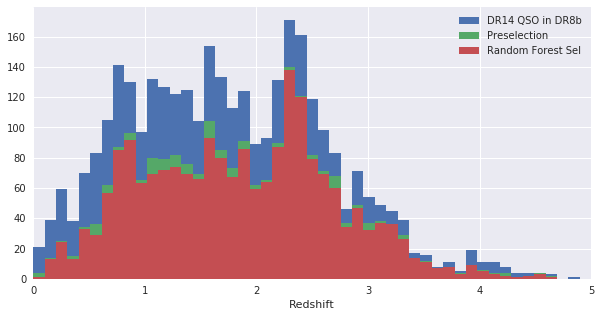

CLASS,DR14,Presel,DESI RF
str6,int64,int64,int64
GALAXY,13309,442,130
QSO,3324,2184,2047
STAR,3316,1668,93


In [22]:
summarize(DR14N, outN)

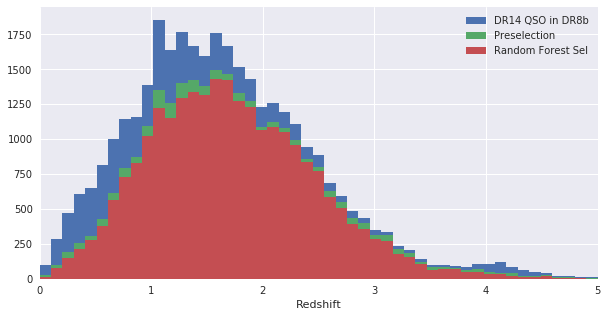

CLASS,DR14,Presel,DESI RF
str6,int64,int64,int64
GALAXY,95216,2896,904
QSO,34312,26981,25077
STAR,49201,28246,382


In [23]:
summarize(DR14S, outS)

## Random Forest Performance and Interpretability

Load the DR3 training data (the more recent DR7 training data is not available at nersc [issue#43](https://github.com/desihub/desitarget/issues/483)):

In [24]:
Training = Path('/global/project/projectdirs/desi/target/qso_training/')
assert Training.exists

In [32]:
def loadDR3():
    bands = 'G', 'R', 'Z', 'W1', 'W2'
    qso_mags = desitarget.train.train_mva_decals.magsExtFromFlux(
       fits.open(Training / 'qso_dr3_nora36-42.fits')[1].data)
    star_mags = desitarget.train.train_mva_decals.magsExtFromFlux(
        fits.open(Training / 'star_dr3_nora36-42_normalized.fits')[1].data)
    Xs, ys = [], []
    for target, mags in zip(('QSO', 'STAR'), (qso_mags, star_mags)):
        ok = np.ones(len(mags[0]), bool)
        for band, mag in zip(bands, mags):
            zero = (mag == 0)
            print(f'Dropping {np.count_nonzero(zero)} {target} sources with zero {band} flux.')
            ok &= ~zero
        nok = np.count_nonzero(ok)
        X, y = pd.DataFrame(), pd.DataFrame()
        y['TARGET'] = np.zeros(nok, int) if target == 'STAR' else np.ones(nok, int)
        X['R'] = mags[1][ok]
        for i, (band1, mag1) in enumerate(zip(bands[:-1], mags[:-1])):
            for (band2, mag2) in zip(bands[i+1:], mags[i+1:]):
                X[f'{band1}-{band2}'] = (mag1 - mag2)[ok]
        Xs.append(X)
        ys.append(y)
    X, y = pd.concat(Xs), pd.concat(ys)
    print(f'Loaded {len(X)} DR3 training objects.')
    return X, y.values.reshape(-1)

X_train, y_train = loadDR3()

Dropping 0 QSO sources with zero G flux.
Dropping 0 QSO sources with zero R flux.
Dropping 0 QSO sources with zero Z flux.
Dropping 0 QSO sources with zero W1 flux.
Dropping 0 QSO sources with zero W2 flux.
Dropping 0 STAR sources with zero G flux.
Dropping 0 STAR sources with zero R flux.
Dropping 0 STAR sources with zero Z flux.
Dropping 0 STAR sources with zero W1 flux.
Dropping 0 STAR sources with zero W2 flux.
Loaded 149396 DR3 training objects.


Train a random forest using the same hyperparameters as `desitarget.train.train_mva_decals`:

In [36]:
gen = np.random.RandomState(seed=123)
%time fit = ensemble.RandomForestClassifier(n_estimators=200, random_state=gen, n_jobs=8).fit(X_train, y_train)

CPU times: user 2min 5s, sys: 95.4 ms, total: 2min 5s
Wall time: 16.3 s


Test on DR8b objects in stripe 82 RA 36-42, which were excluded from the training sample:

In [37]:
DR8b_test = (outS['STRIPE82'] == 1) & (outS['RA'] > 36) & (outS['RA'] < 42)
X_test = outS[DR8b_test][outS.colnames[:11]].to_pandas()
y_test = 1 * (outS[DR8b_test]['CLASS'] == 2)

Display the estimated importance of each feature to the trained random forest (from shuffling each feature, to preserve 1-pt stats, and measuring score change):

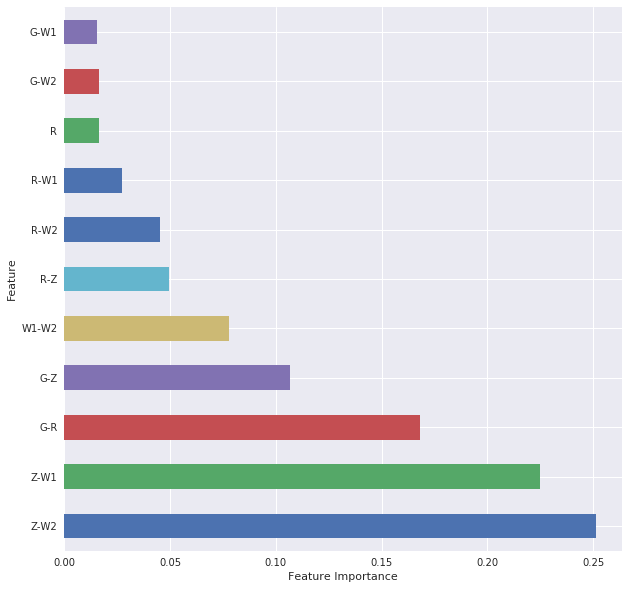

In [38]:
importance = pd.DataFrame(
    {'Feature': X_test.columns, 'Importance': fit.feature_importances_}
).sort_values(by='Importance', ascending=False)
importance.plot('Feature', 'Importance', 'barh', figsize=(10, 10), legend=False)
plt.xlabel('Feature Importance');

Train a smaller model that only uses the 4 most important features:

In [56]:
nbest = 4
best_features = importance[:nbest]['Feature']
importance[:nbest]

,Feature,Importance
9,Z-W2,0.251299
8,Z-W1,0.225020
1,G-R,0.168336
2,G-Z,0.106926


Optimize hyperparameters for training a small model, using a 20% validation sample:

In [52]:
def optimize(max_features=(2, 3, 4), n_estimators=(10, 20, 30, 40, 50, 60, 80, 100, 150, 200), seed=123):
    gen = np.random.RandomState(seed)
    # Hold out a 20% validation sample for hyperparam optimization.
    X_t, X_v, y_t, y_v = model_selection.train_test_split(X_train[best_features], y_train, test_size=0.2, random_state=gen)
    for m in max_features:
        score = []
        for n in n_estimators:
            model = ensemble.RandomForestClassifier(
                n_estimators=n, max_features=m, random_state=gen, n_jobs=8).fit(X_t, y_t)
            score.append(model.score(X_v, y_v))
        plt.plot(n_estimators, score, 'o-', label=f'max_features={m}')
    plt.xlabel('RandomForest n_estimators')
    plt.ylabel('Validation sample mean accuracy')
    plt.legend()

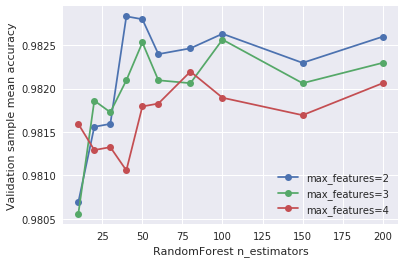

In [53]:
optimize()

Train a small model with optimized hyperparameters:

In [55]:
gen = np.random.RandomState(seed=123)
%time small_fit = ensemble.RandomForestClassifier(n_estimators=50, max_features=2, random_state=gen, n_jobs=8).fit(X_train[best_features], y_train)

CPU times: user 24.7 s, sys: 35.9 ms, total: 24.8 s
Wall time: 3.38 s


Recalculate feature importance for the small model:

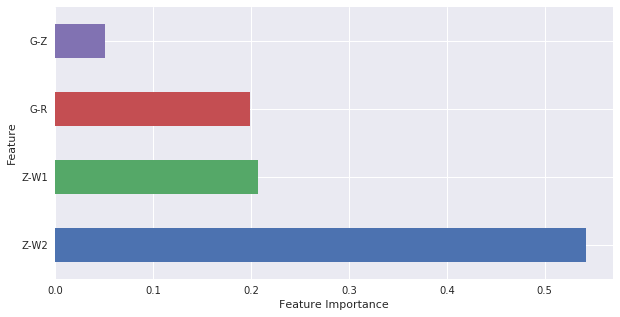

In [57]:
small_importance = pd.DataFrame(
    {'Feature': X_test[best_features].columns, 'Importance': small_fit.feature_importances_}
).sort_values(by='Importance', ascending=False)
small_importance.plot('Feature', 'Importance', 'barh', figsize=(10, 5), legend=False)
plt.xlabel('Feature Importance');

Calculate the QSO probability predicted by each tree, for each test object, using both models (FULL / SMALL):

In [65]:
full_prob = np.array([tree.predict_proba(X_test) for tree in fit.estimators_])[:,:,1]

In [66]:
small_prob = np.array([tree.predict_proba(X_test[best_features]) for tree in small_fit.estimators_])[:,:,1]

All leaf nodes in all trees (of both models) are unanimous on the classification:

In [67]:
np.unique(full_prob), np.unique(small_prob)

(array([ 0.,  1.]), array([ 0.,  1.]))

However, the ensemble average of trees gives a probability per source. Compare the full and small models for each DR14 class:

In [68]:
qso_prob = np.array([full_prob.mean(axis=0), small_prob.mean(axis=0)])

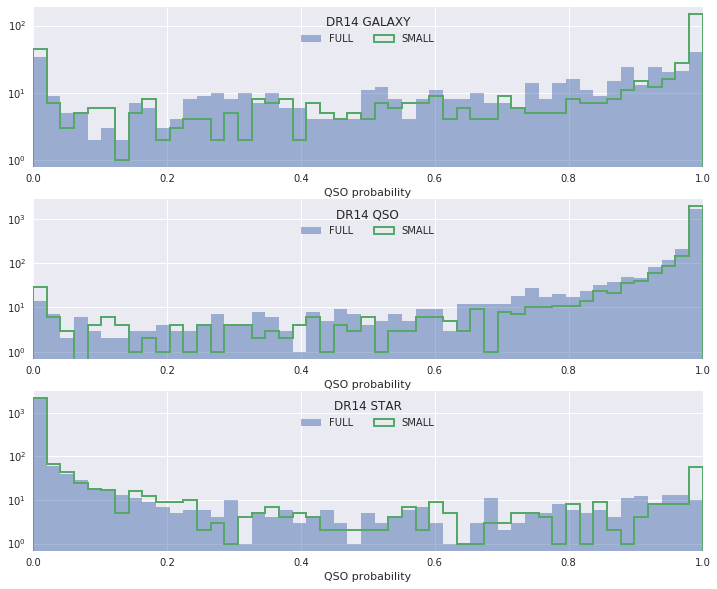

In [69]:
def plot_test():
    bins = np.linspace(0, 1, 50)
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))
    for C, clsname in enumerate(('GALAXY', 'QSO', 'STAR')):
        sel = outS[DR8b_test]['CLASS'] == C+1
        for i, (name, style) in enumerate(zip(('FULL', 'SMALL'), (dict(alpha=0.5), dict(histtype='step', lw=2)))):
            ax = axes[C]
            ax.hist(qso_prob[i][sel], bins=bins, label=name, **style)
            ax.legend(loc='upper center', ncol=2, title=f'DR14 {clsname}')
            ax.set_yscale('log')
            ax.set_xlabel('QSO probability')
            ax.set_xlim(0, 1)
            
plot_test()

Plot the distribution of the 4 most important features for each DR14 source type:

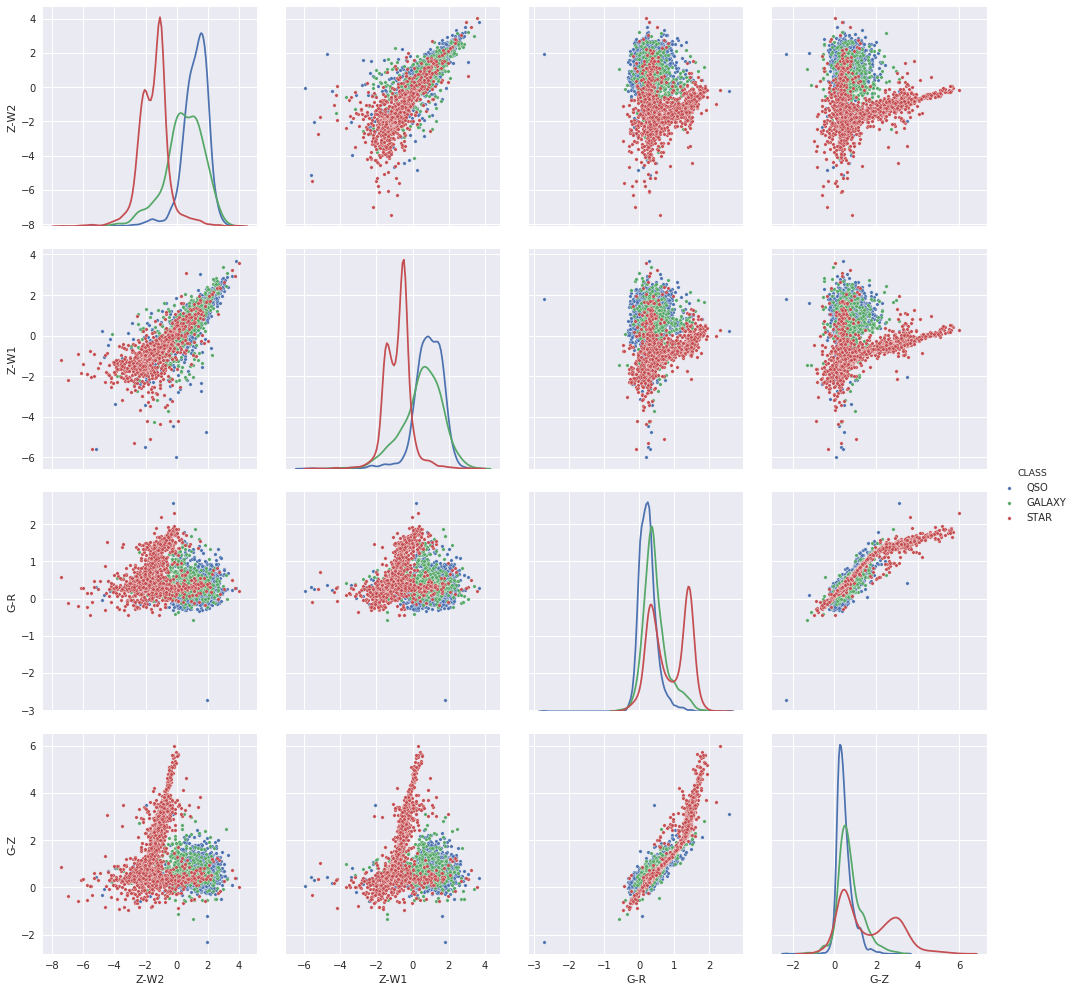

In [136]:
def plot_features():
    df = X_test[best_features].copy()
    C = outS[DR8b_test]['CLASS']
    df['CLASS'] = [('GALAXY', 'QSO', 'STAR')[c-1] for c in C]    
    sns.pairplot(df, hue='CLASS', markers='.', diag_kind='kde', size=3.5)
    
plot_features()